# CNN-lytical Assignment-2
<center>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS7fZ0PJ4leQi4qtXR5Egv5YILqQqvzVSNtFg&usqp=CAU">
</center>

*  In this assignment, we will build a classifier for MNIST from using [PyTorch](https://pytorch.org/docs/stable/index.html). 

*   We will be using the same dataset as the previous assignment for MNIST. **Do not** use the complete MNIST dataset, even though PyTorch makes it really easy.

*   No limitations on your model this time, just don't use CNNs now, that's up next week.

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Also remember to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import pickle
from sklearn.model_selection import StratifiedShuffleSplit
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.init import xavier_uniform_

np.random.seed(1337)
torch.random.manual_seed(1337)

## Load *Dataset*
Use the pickle file shared for the previous assignment here.

In [3]:
# mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# load the data set
train_data_path = "/content/drive/MyDrive/CNN-lytical/MNIST/train_data.pkl"
with open(train_data_path, 'rb') as train_data_pickle:
  train_data = pickle.load(train_data_pickle)

In [5]:
# print the shapes of the data
print(train_data['X'].shape)
print(train_data['y'].shape)

(60000, 784)
(60000, 1)


In [86]:
# load the data set
X = np.array(train_data['X'], dtype=np.float32)
y = np.squeeze(train_data['y'])

# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in sss.split(X, y):
  X_train, y_train = X[train_index], y[train_index]
  X_test, y_test = X[test_index], y[test_index]

# Print shapes
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (48000, 784)
y_train: (48000,)
X_test: (12000, 784)
y_test: (12000,)


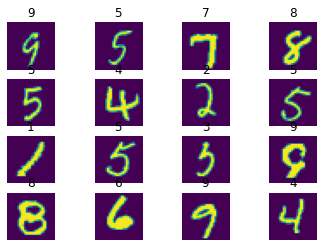

In [23]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
for i in range(1, 17):
  plt.subplot(4, 4, i)
  idx = np.random.randint(X_train.shape[0])
  plt.title(y_train[idx].item())
  plt.axis('off')
  plt.imshow(X_train[idx].reshape(28, 28))

In [87]:
# normalize the dataset, won't be doing it here in later assignments
#Unconventional normalisation -> axis=1 is intentional, *not* a mistake
X_train = (X_train - np.mean(X_train, axis=1, keepdims=True))/np.std(X_train, axis=1, keepdims=True)
X_test = (X_test - np.mean(X_test, axis=1, keepdims=True))/np.std(X_test, axis=1, keepdims=True)

X_train = torch.from_numpy(X_train); y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test); y_test = torch.from_numpy(y_test)

## Creating a Dataset Class
In PyTorch, there is existing implementation of batch-splitting. You don't need to do it manually over here. Instead, just define a Dataset class and a Dataloader wrapping it.

A dataset class must have 3 functions - ```__init__```, ```__len__```, ```__getitem__```. Their names are pretty self-explanatory. You can read more about this [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).


**Note** - Things like normalization, augmentation etc. which are related to the dataset are all done in this class. However, because this assignment doesn't deal with MNIST images but rather feature vectors, this part is being skipped here and will be discussed in Assignment 3.

In [19]:
# define your dataset class
class MNISTDataset(Dataset):
  def __init__(self, dataX, dataY):
    self.X = dataX
    self.y = torch.squeeze(dataY)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return [self.X[idx], self.y[idx]]

## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Linear```](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
- [```nn.ReLU```](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- [```nn.BatchNorm1d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)


In [25]:
# define a child class of nn.Module for your model
# specify the architecture here itself
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.lin1 = nn.Linear(784, 40)
    self.relu1 = nn.ReLU()
    self.lin2 = nn.Linear(40, 30)
    self.relu2 = nn.ReLU()
    self.lin3 = nn.Linear(30, 10)
    self.softmax = nn.Softmax(dim=1)
  
  def forward(self, x):
    x = self.lin1(x)
    x = self.relu1(x)
    x = self.lin2(x)
    x = self.relu2(x)
    x = self.lin3(x)
    x = self.softmax(x)

    return x

## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [11]:
def train(model, optimizer, criterion, train_loader, display_step=None):
    model.train()

    for data, target in train_loader:
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()

## Initialize weights
Write a small function to initialize weights for your model. You don't need to do it individually for each layer, there are ways to do it in a simple ```for``` loop.

In [12]:
def init_weights(model):
    xavier_uniform_(model.lin1.weight)
    xavier_uniform_(model.lin2.weight)
    xavier_uniform_(model.lin3.weight)

## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [66]:
def predict(model, test_loader):
  model.eval()
  pred = None
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      if pred == None:
        pred = output.argmax(dim=1, keepdims=True)
        continue
      pred = torch.stack((pred, output.argmax(dim=1, keepdims=True)))
  return torch.squeeze(pred)

In [73]:
def accuracy(pred, labels):
    return (pred == labels).sum() / labels.shape[0]

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [100]:
np.random.seed(1337)
torch.random.manual_seed(1337)

model = Net()
train_dataset = MNISTDataset(X_train, y_train)
test_dataset = MNISTDataset(X_test, y_test)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

init_weights(model)

In [101]:
for epoch in range(200):
  train(model, optimizer, criterion, train_loader)
  if (epoch+1)%10 == 0:
    print("Epoch: {}".format(epoch+1)) 

Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
Epoch: 110
Epoch: 120
Epoch: 130
Epoch: 140
Epoch: 150
Epoch: 160
Epoch: 170
Epoch: 180
Epoch: 190
Epoch: 200


## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [102]:
test_loader = DataLoader(test_dataset, batch_size=test_dataset.__len__(), shuffle=False)

print(accuracy(predict(model, test_loader), y_test))

tensor(0.9398)


## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Other than this, save the trained model in a file named ```ass_2.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py``` class file and the ```ass_2.pt``` model-weights file to the repository.

In [95]:
final_model = model

In [96]:
from google.colab import files
torch.save(final_model, 'ass_2.pt')
files.download('ass_2.pt') # download the file from the Colab session for submission

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Check if it got saved right!